# NDSEG Fellowship Proposal Plots

A notebook to construct plots illustrating my proposed methods for my NDSEG project proposal.

In [1]:
library(mvtnorm)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(ks)

ERROR: Error in library(ks): there is no package called ‘ks’


In [2]:
source('/global/u1/j/jbbutler/isolines_uq/scripts/R/confidenceRegions.R')

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Linking to GEOS 3.10.2, GDAL 3.5.0, PROJ 9.0.0; sf_use_s2() is TRUE


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




## Plot 1: Plot an Example of an Isoline and a True Isoline

In [3]:
p <- 0.01
lb <- -5
ub <- 5
gticks <- 250
est_gsize <- 500
grid <- expand.grid(X1 = seq(lb, ub, length.out = gticks),
                    X2 = seq(lb, ub, length.out = gticks))

In [4]:
set.seed(12222)

n <- 2000

fake_dat <- data.frame(rmvt(n, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

xmin <- c(min(min(fake_dat[,1]), lb), min(min(fake_dat[,2]), lb))
xmax <- c(max(max(fake_dat[,1]), ub), max(max(fake_dat[,2]), ub))

surv_func <- kcde(fake_dat, tail.flag = 'upper', gridsize = est_gsize, eval.points = grid, xmin = xmin, xmax = xmax)

In [5]:
isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))

In [6]:
xGrid <- surv_func$eval.points[[1]]
yGrid <- surv_func$eval.points[[2]]
surv <- as.vector(surv_func$estimate)
survMtx <- matrix(surv, nrow = gticks, ncol = gticks)

In [7]:
contourList <- contourLines(x = sort(unique(xGrid)), y = sort(unique(yGrid)), z = survMtx, levels = p)
contourOrig <- data.frame(cbind(contourList[[1]]$x, contourList[[1]]$y))

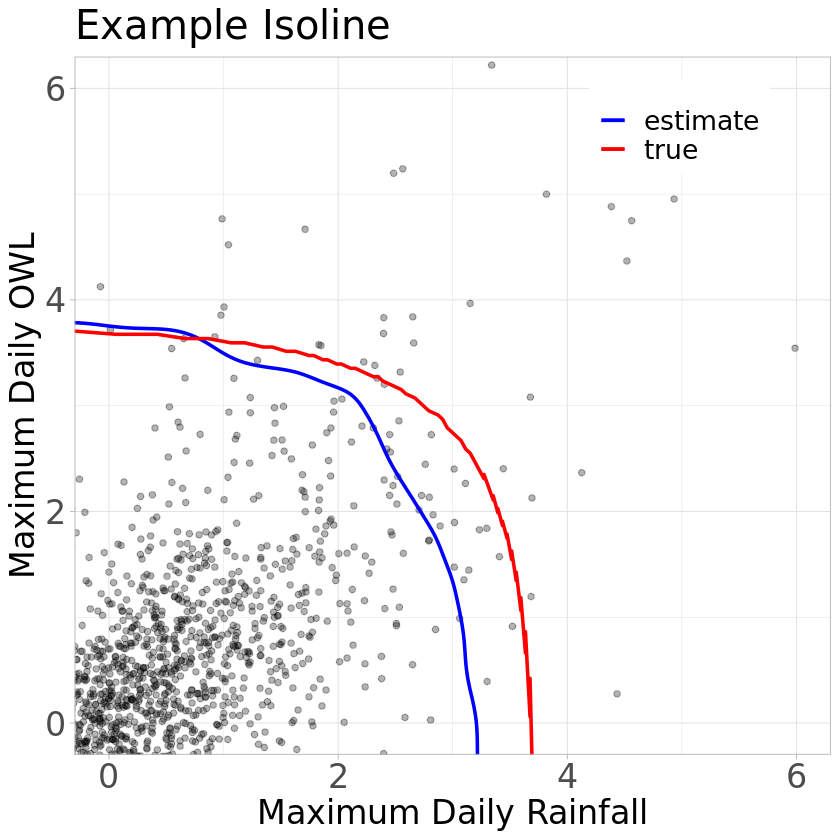

In [27]:
ggplot() + geom_point(data = fake_dat, aes(x = X1, y = X2), alpha = 0.3) + 
geom_line(data = contourOrig, aes(x = X1, y = X2, col = 'estimate'), size = 1) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_color_manual(values = c('estimate' = 'blue', 'true' = 'red')) +
xlab('Maximum Daily Rainfall') + ylab('Maximum Daily OWL') +
ggtitle('Example Isoline') +
coord_cartesian(ylim=c(0, 6), xlim = c(0, 6)) + theme_light() +
theme(legend.position = c(0.8, 0.9), 
      legend.title = element_blank(), 
      #panel.border = element_rect(color = "black", fill=NA), 
      #legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), text = element_text(size = 20))





## Plot 2: Example of a Confidence Region for an Isoline

In [12]:
boot_gsize <- 150
beta_func <- function(n) 1/n
B <- 500
xmin <- c(min(min(fake_dat$X1), lb), min(min(fake_dat$X2), lb))
xmax <- c(max(max(fake_dat$X1), ub), max(max(fake_dat$X2), ub))
alpha <- 0.05

In [13]:
region_out <- drawBaseRegion(fake_dat, grid, est_gsize, boot_gsize, xmin, xmax, alpha, p, beta_func, B)

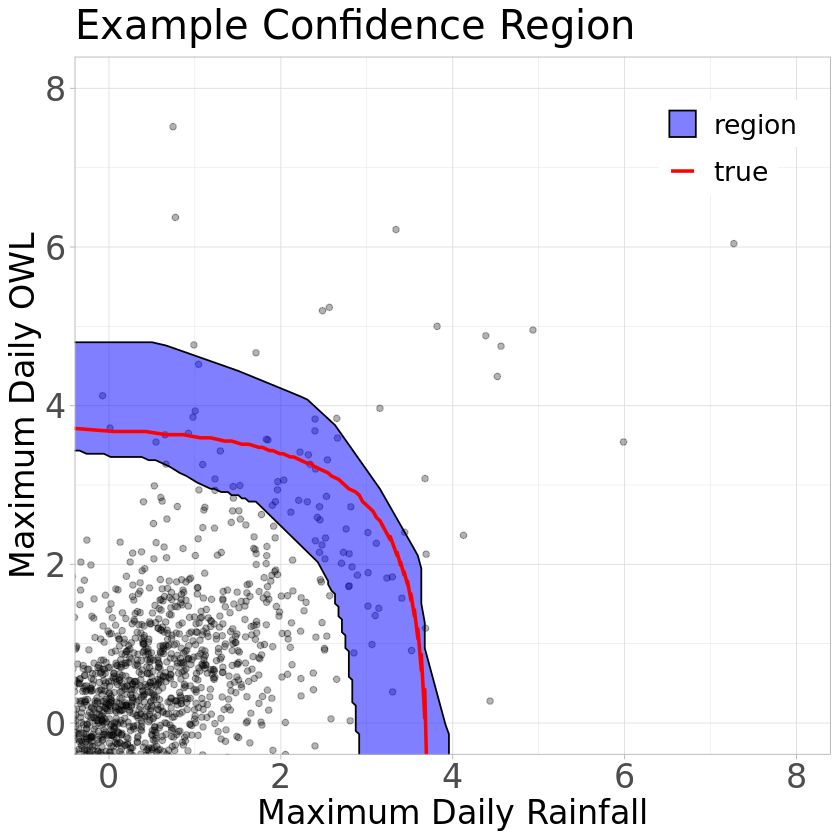

In [35]:
ggplot() + geom_point(data = fake_dat, aes(x = X1, y = X2), alpha = 0.3) + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'region'), color = 'black', alpha = 0.5) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_fill_manual(values = c('region' = 'blue')) +
scale_color_manual(values = c('true' = 'red')) +
xlab('Maximum Daily Rainfall') + ylab('Maximum Daily OWL') +
ggtitle('Example Confidence Region') +
coord_cartesian(ylim=c(0, 8), xlim = c(0, 8)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
#     legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20))

## Plot 3: Example of a Projected Confidence Region

In [28]:
proj_p <- 0.001

In [29]:
proj_out <- projectBaseRegion(base_out = region_out, proj_p = proj_p, asympIndep = FALSE, lb = lb, ub = ub)
base_isoline <- isoline
proj_isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', proj_p, '_bivt.RData'))

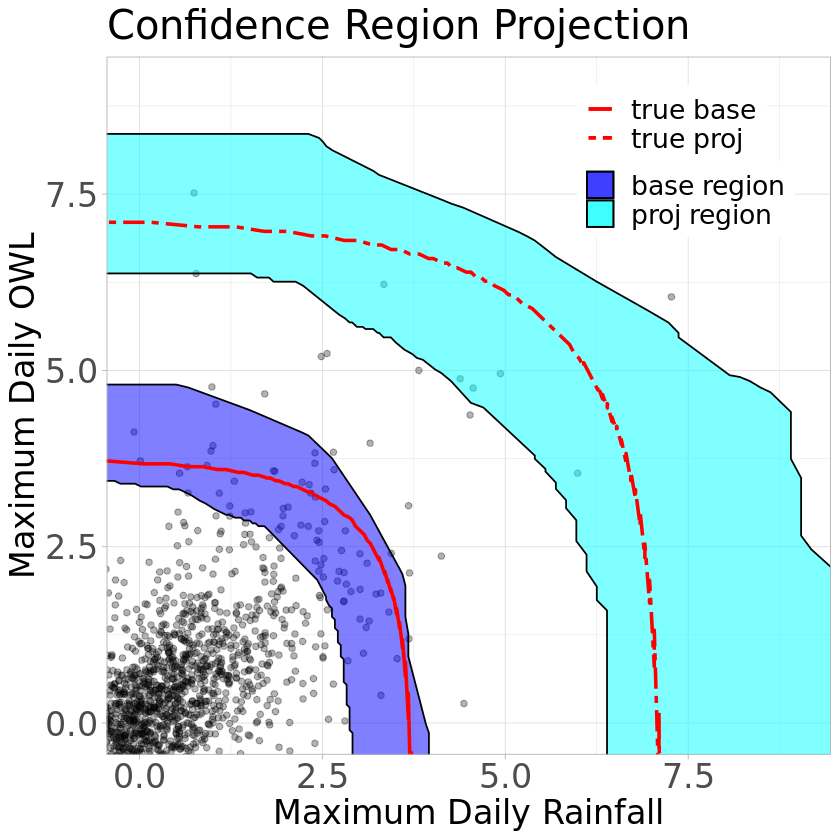

In [36]:
ggplot() + geom_point(data = fake_dat, aes(x = X1, y = X2), alpha = 0.3) + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'base region'), color = 'black', alpha = 0.5) +
geom_polygon(data = data.frame(proj_out$proj_region_poly[[1]]), aes(x = X1, y = X2, fill = 'proj region'), color = 'black', alpha = 0.5) +
geom_line(data = base_isoline, aes(x = X1, y = X2, linetype = 'true base'), color = 'red', size = 1) +
geom_line(data = proj_isoline, aes(x = X1, y = X2, linetype = 'true proj'), color = 'red', size = 1) +
scale_linetype_manual(values = c('true base' = 'solid', 'true proj' = 'twodash')) +
scale_fill_manual(values = c('base region' = 'blue', 'proj region' = 'cyan')) +
xlab('Maximum Daily Rainfall') + ylab('Maximum Daily OWL') +
ggtitle('Confidence Region Projection') +
coord_cartesian(ylim=c(0, 9), xlim = c(0, 9)) +
theme_light() +
theme(legend.position = c(0.8, 0.85), 
      legend.title = element_blank(), 
      legend.spacing.y = unit(0, "cm"), 
      #panel.border = element_rect(color = "black", fill=NA), 
      #legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      text = element_text(size = 20))


